# PROYECTO COMPLETO: Análisis Bitcoin vs Dólar ETF
# Autor: Daniel Alejandro Hernández Gálvez

# # Análisis de la Relación entre Bitcoin y ETF del Dólar
# 
# ## Abstract
# Este proyecto busca analizar la posible relación entre los precios del Bitcoin (la criptomoneda más importante del mercado) y un ETF que sigue el valor del dólar estadounidense. El dataset contiene información diaria de precios (apertura, cierre, máximo, mínimo), volumen de operaciones y precios ajustados para ambos instrumentos durante el año 2021.
# 
# La hipótesis principal es que existe una correlación inversa entre estos activos, donde cuando el dólar se fortalece, el Bitcoin tiende a debilitarse y viceversa. Este análisis es relevante porque ayudaría a entender si el Bitcoin está funcionando como cobertura contra la depreciación del dólar, una de las narrativas comunes en el mercado de criptomonedas.
# 
# Utilizaremos técnicas de visualización y análisis estadístico para explorar esta relación, incluyendo gráficos de dispersión, mapas de calor de correlación y análisis de series temporales. El proyecto aportará evidencia empírica sobre esta relación que es frecuentemente discutida pero poco analizada con rigor cuantitativo.
# 
# **Audiencia objetivo:** Traders, inversores institucionales, gestores de portafolio y académicos interesados en mercados financieros y criptomonedas.
# 
# ## Preguntas e Hipótesis
# 
# **Preguntas de investigación:**
# - ¿Existe una correlación significativa entre los precios del Bitcoin y el ETF del dólar?
# - ¿Cómo evoluciona esta relación a lo largo del tiempo?
# - ¿El volumen de operaciones afecta esta relación?
# # **Hipótesis:**
# - H1: Existe una correlación negativa entre los precios de cierre del Bitcoin y del ETF del dólar.
# - H2: Los periodos de alta volatilidad en el Bitcoin coinciden con movimientos opuestos en el dólar.
# - H3: La correlación es más fuerte en periodos de mayor volumen de operaciones.



In [ ]:

# # 1. Configuración e Importación de Librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Librerías importadas correctamente")


df = pd.read_csv('dataset_bitcoin_dolar.csv', parse_dates=['Date'])
df = df.sort_values('Date')

print("📊 Dataset original cargado:")
print(f"Dimensiones: {df.shape}")
print(f"Periodo: {df['Date'].min()} a {df['Date'].max()}")
print(f"Número de días: {len(df)}")


# Verificar valores perdidos
print("🔍 Valores perdidos por columna:")
print(df.isnull().sum())


# Función para enriquecer el dataset
def enrich_dataset(df):
    """Enriquecer el dataset con variables técnicas y simulaciones de datos externos"""
    
    df_enriched = df.copy()
    
    # Simular datos de Ethereum (para comparación)
    np.random.seed(42)  # Para reproducibilidad
    eth_start = 1800  # Precio inicial simulado de ETH
    eth_returns = np.random.normal(0.001, 0.04, len(df))  # Retornos simulados
    eth_prices = [eth_start]
    
    for ret in eth_returns[1:]:
        eth_prices.append(eth_prices[-1] * (1 + ret))
    
    df_enriched['ETH_Close'] = eth_prices
    df_enriched['ETH_Volume'] = np.random.lognormal(14, 1, len(df))
    
    # Simular indicadores macroeconómicos
    dates = df_enriched['Date']
    days_from_start = (dates - dates.min()).dt.days
    
    # VIX (Volatilidad del mercado)
    df_enriched['VIX'] = 20 + 10 * np.sin(days_from_start / 30) + np.random.normal(0, 2, len(df))
    
    # Fear & Greed Index
    df_enriched['Fear_Greed_Index'] = np.random.randint(20, 80, len(df))
    
    # Tasas de interés (simuladas)
    df_enriched['Interest_Rate'] = 0.1 + (days_from_start / 1000) * 0.15
    
    return df_enriched

# Aplicar enriquecimiento
df_enriched = enrich_dataset(df)
print("✅ Dataset enriquecido con variables adicionales")



✅ Librerías importadas correctamente
📊 Dataset original cargado:
Dimensiones: (1000, 13)
Periodo: 2021-08-23 00:00:00 a 2025-08-15 00:00:00
Número de días: 1000
🔍 Valores perdidos por columna:
Date                 0
Bitcoin_AdjClose     0
Bitcoin_Close        0
Bitcoin_High         0
Bitcoin_Low          0
Bitcoin_Open         0
Bitcoin_Volume       0
DolarETF_AdjClose    0
DolarETF_Close       0
DolarETF_High        0
DolarETF_Low         0
DolarETF_Open        0
DolarETF_Volume      0
dtype: int64
✅ Dataset enriquecido con variables adicionales


In [4]:
# %%
# Crear variables técnicas
def create_technical_features(df):
    """Crear indicadores técnicos y features de mercado"""
    
    df_tech = df.copy()
    
    # 1. Retornos diarios
    df_tech['BTC_Return'] = df_tech['Bitcoin_Close'].pct_change() * 100
    df_tech['DolarETF_Return'] = df_tech['DolarETF_Close'].pct_change() * 100
    df_tech['ETH_Return'] = df_tech['ETH_Close'].pct_change() * 100
    
    # 2. Volatilidad rolling (21 días ~ 1 mes)
    df_tech['BTC_Volatility_21d'] = df_tech['BTC_Return'].rolling(window=21).std()
    df_tech['Dolar_Volatility_21d'] = df_tech['DolarETF_Return'].rolling(window=21).std()
    
    # 3. Medias móviles
    df_tech['BTC_MA_7'] = df_tech['Bitcoin_Close'].rolling(window=7).mean()
    df_tech['BTC_MA_21'] = df_tech['Bitcoin_Close'].rolling(window=21).mean()
    df_tech['Dolar_MA_21'] = df_tech['DolarETF_Close'].rolling(window=21).mean()
    
    # 4. Relación BTC/ETH
    df_tech['BTC_ETH_Ratio'] = df_tech['Bitcoin_Close'] / df_tech['ETH_Close']
    
    # 5. Momentum
    df_tech['BTC_Momentum_7d'] = df_tech['Bitcoin_Close'] / df_tech['Bitcoin_Close'].shift(7) - 1
    df_tech['Dolar_Momentum_7d'] = df_tech['DolarETF_Close'] / df_tech['DolarETF_Close'].shift(7) - 1
    
    # 6. Bandas de Bollinger (BTC)
    df_tech['BTC_Middle_Band'] = df_tech['Bitcoin_Close'].rolling(20).mean()
    df_tech['BTC_Upper_Band'] = df_tech['BTC_Middle_Band'] + 2 * df_tech['Bitcoin_Close'].rolling(20).std()
    df_tech['BTC_Lower_Band'] = df_tech['BTC_Middle_Band'] - 2 * df_tech['Bitcoin_Close'].rolling(20).std()
    df_tech['BTC_Bollinger_Position'] = (df_tech['Bitcoin_Close'] - df_tech['BTC_Lower_Band']) / (df_tech['BTC_Upper_Band'] - df_tech['BTC_Lower_Band'])
    
    # 7. RSI (Relative Strength Index) simplificado
    delta = df_tech['Bitcoin_Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df_tech['BTC_RSI'] = 100 - (100 / (1 + rs))
    
    # Eliminar filas con NaN
    df_tech = df_tech.dropna()
    
    return df_tech

# Aplicar creación de features técnicas
df_final = create_technical_features(df_enriched)

print("✅ Features técnicas creadas")
print(f"📊 Dataset final: {df_final.shape[0]} filas, {df_final.shape[1]} columnas")
# Estadísticas descriptivas del dataset final
print("📈 ESTADÍSTICAS DESCRIPTIVAS DEL DATASET FINAL")
print("="*50)

print("\nBitcoin Close:")
print(df_final['Bitcoin_Close'].describe())

print("\nDólar ETF Close:")
print(df_final['DolarETF_Close'].describe())

print("\nETH Close:")
print(df_final['ETH_Close'].describe())

✅ Features técnicas creadas
📊 Dataset final: 979 filas, 34 columnas
📈 ESTADÍSTICAS DESCRIPTIVAS DEL DATASET FINAL

Bitcoin Close:
count       979.000000
mean      51417.653990
std       28578.697018
min       15787.284180
25%       27222.692383
50%       43185.859375
75%       67346.718750
max      123344.062500
Name: Bitcoin_Close, dtype: float64

Dólar ETF Close:
count    979.000000
mean      28.097783
std        1.257116
min       24.980000
25%       27.450001
50%       28.250000
75%       28.935000
max       30.670000
Name: DolarETF_Close, dtype: float64

ETH Close:
count     979.000000
mean     2174.585789
std      1155.889544
min      1064.062466
25%      1454.823381
50%      1766.598466
75%      2375.850011
max      6689.971544
Name: ETH_Close, dtype: float64


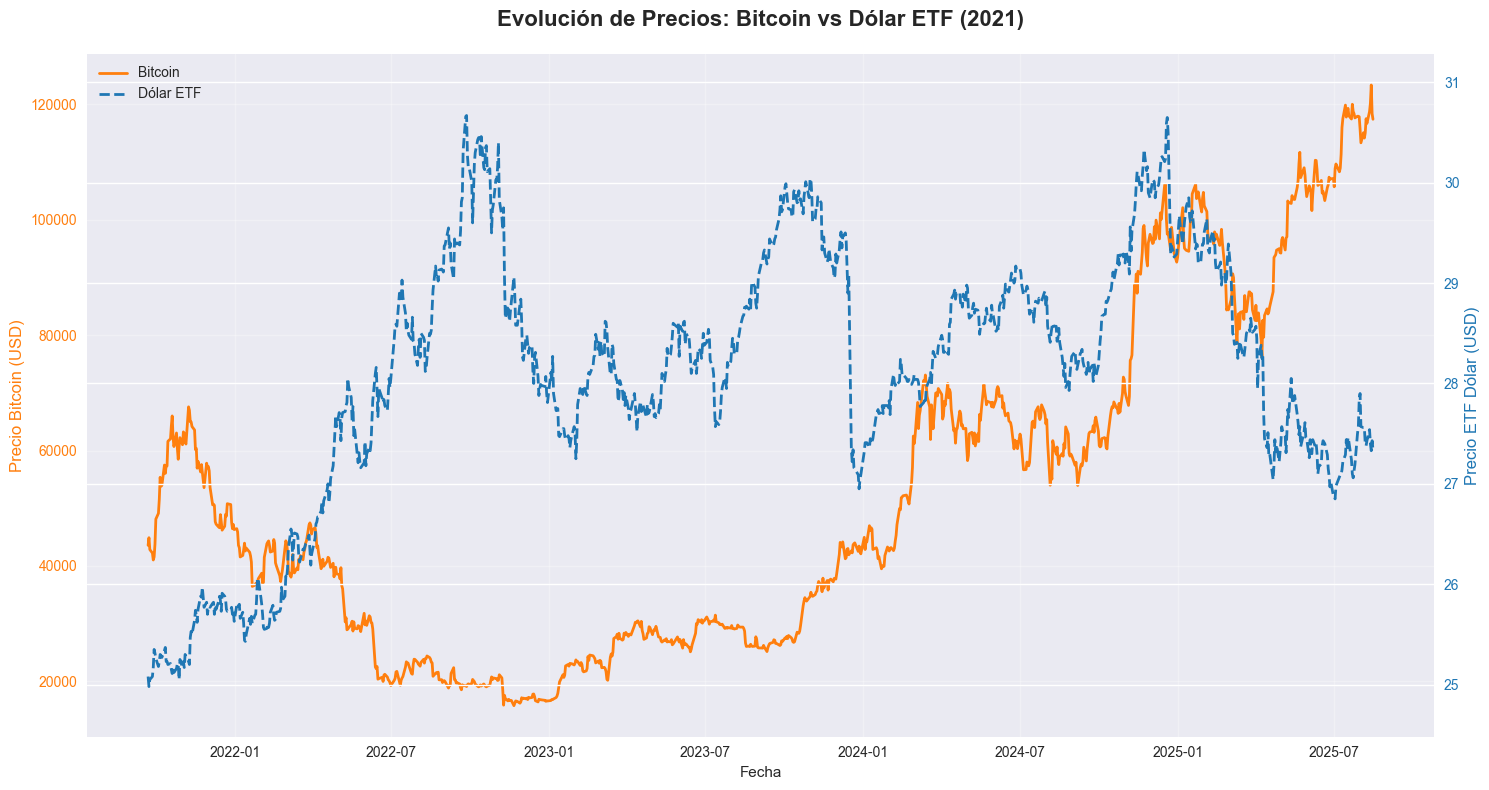

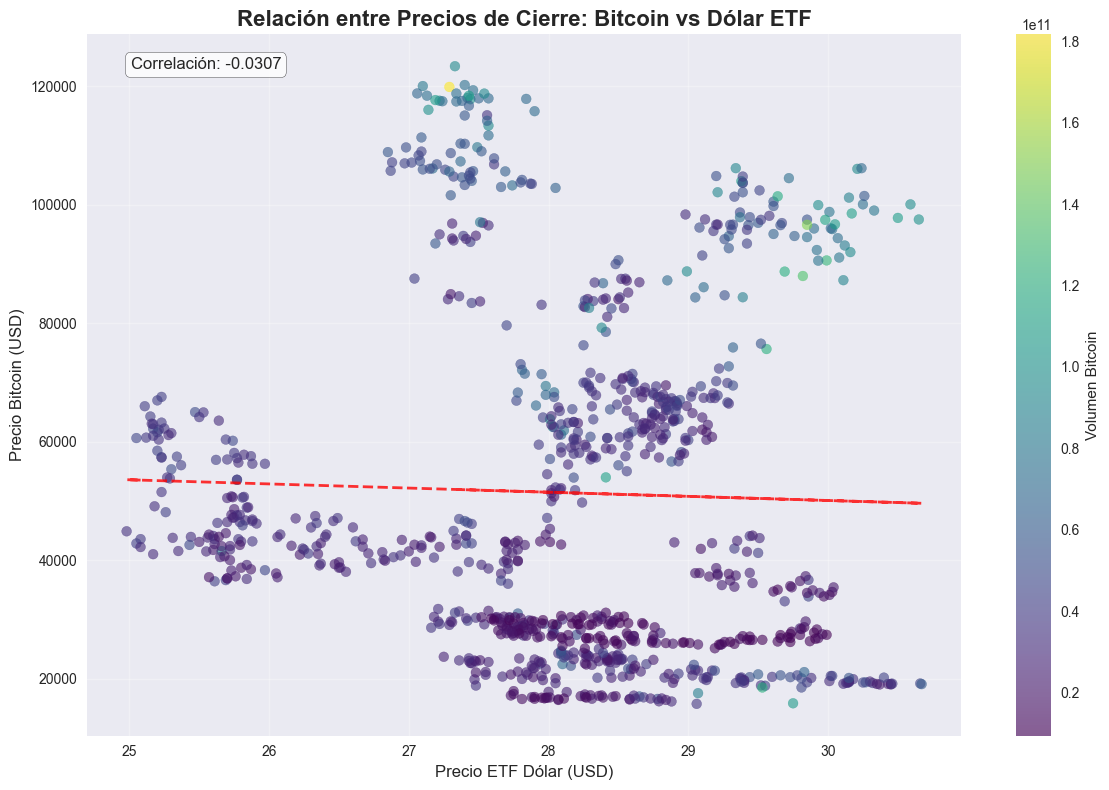

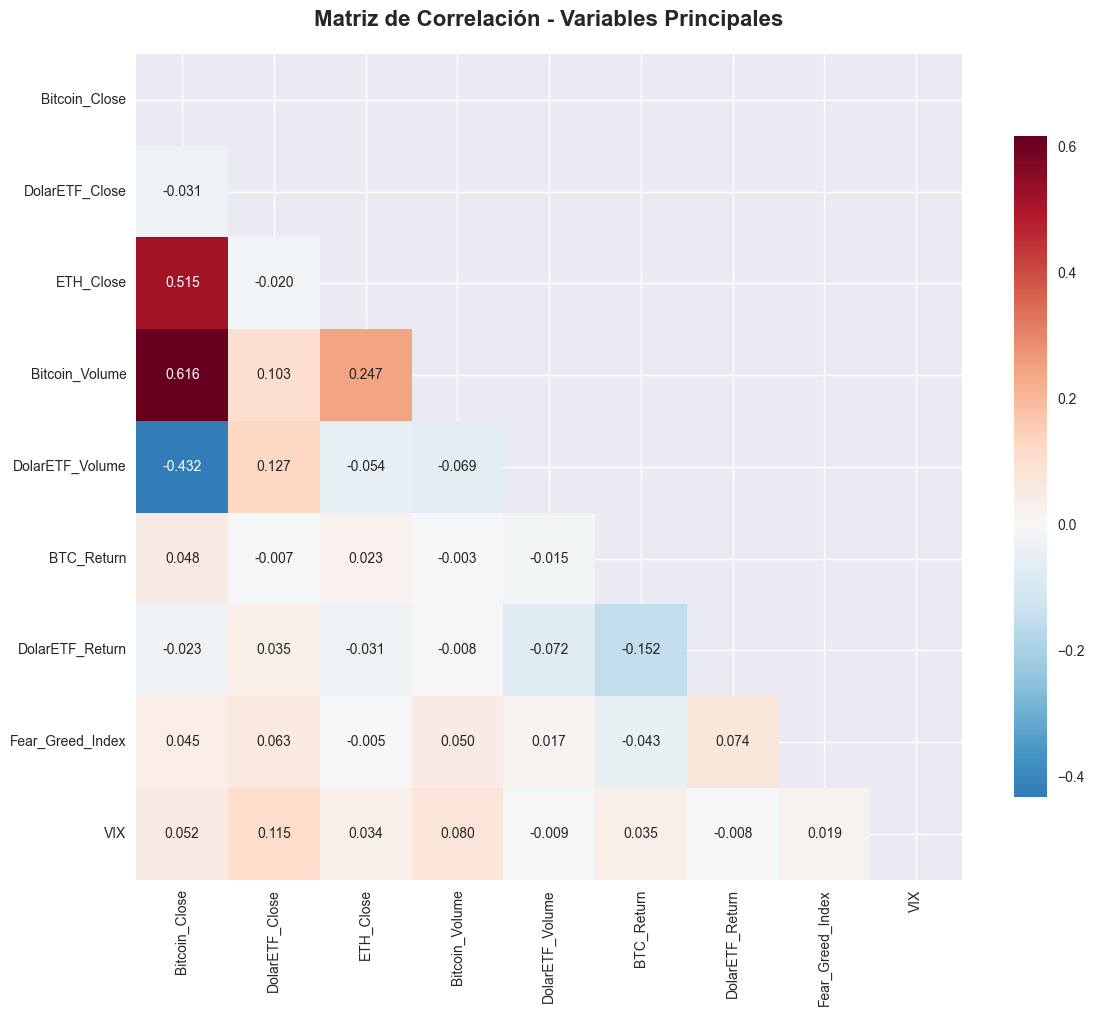

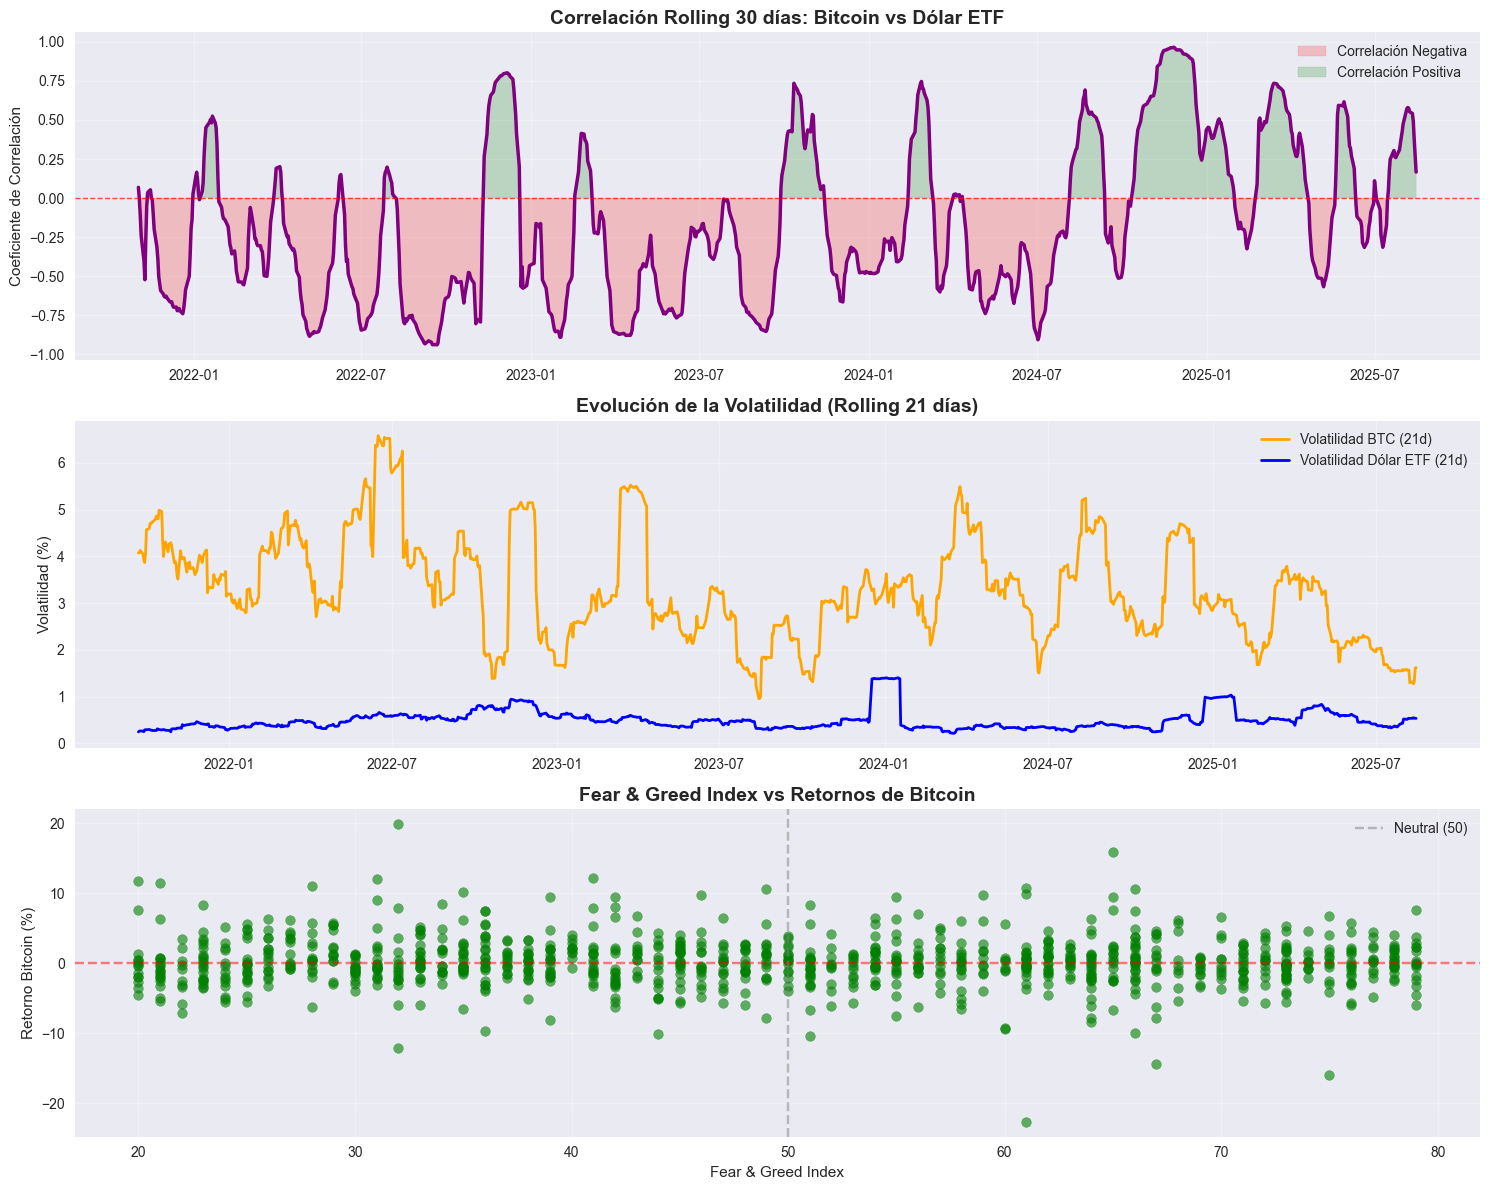

In [5]:
# %%
# Gráfico 1: Evolución temporal de ambos precios
fig, ax1 = plt.subplots(figsize=(15, 8))

# Gráfico de Bitcoin (eje izquierdo)
color = 'tab:orange'
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Precio Bitcoin (USD)', color=color, fontsize=12)
ax1.plot(df_final['Date'], df_final['Bitcoin_Close'], color=color, label='Bitcoin', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)
ax1.set_title('Evolución de Precios: Bitcoin vs Dólar ETF (2021)', fontsize=16, fontweight='bold', pad=20)

# Crear eje secundario para el dólar
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Precio ETF Dólar (USD)', color=color, fontsize=12) 
ax2.plot(df_final['Date'], df_final['DolarETF_Close'], color=color, linestyle='--', linewidth=2, label='Dólar ETF')
ax2.tick_params(axis='y', labelcolor=color)

# Ajustar rangos para mejor visualización
ax2.set_ylim(df_final['DolarETF_Close'].min()*0.98, df_final['DolarETF_Close'].max()*1.02)

# Leyenda unificada
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 3.2 Gráfico de Dispersión con Volumen

# %%
# Gráfico 2: Gráfico de dispersión con línea de regresión
plt.figure(figsize=(12, 8))

# Crear scatter plot con color por volumen
scatter = plt.scatter(df_final['DolarETF_Close'], df_final['Bitcoin_Close'], 
                     c=df_final['Bitcoin_Volume'], cmap='viridis', 
                     alpha=0.6, s=50)
plt.colorbar(scatter, label='Volumen Bitcoin')

# Añadir línea de regresión
z = np.polyfit(df_final['DolarETF_Close'], df_final['Bitcoin_Close'], 1)
p = np.poly1d(z)
plt.plot(df_final['DolarETF_Close'], p(df_final['DolarETF_Close']), "r--", alpha=0.8, linewidth=2)

plt.title('Relación entre Precios de Cierre: Bitcoin vs Dólar ETF', fontsize=16, fontweight='bold')
plt.xlabel('Precio ETF Dólar (USD)', fontsize=12)
plt.ylabel('Precio Bitcoin (USD)', fontsize=12)
plt.grid(True, alpha=0.3)

# Añadir coeficiente de correlación
correlation = df_final['Bitcoin_Close'].corr(df_final['DolarETF_Close'])
plt.text(0.05, 0.95, f'Correlación: {correlation:.4f}', 
         transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 3.3 Matriz de Correlación Completa

# %%
# Gráfico 3: Mapa de calor de correlaciones
corr_cols = ['Bitcoin_Close', 'DolarETF_Close', 'ETH_Close', 
             'Bitcoin_Volume', 'DolarETF_Volume', 'BTC_Return',
             'DolarETF_Return', 'Fear_Greed_Index', 'VIX']

corr_matrix = df_final[corr_cols].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, fmt='.3f', cbar_kws={"shrink": .8}, 
            annot_kws={"size": 10})

plt.title('Matriz de Correlación - Variables Principales', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 3.4 Análisis de Correlación Rolling (Para H2)

# %%
# Gráfico 4: Correlación Rolling y Volatilidad
def plot_rolling_analysis(df, window=30):
    """Gráfico de correlación rolling y análisis de volatilidad"""
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
    
    # 1. Correlación rolling
    rolling_corr = df['Bitcoin_Close'].rolling(window=window).corr(df['DolarETF_Close'])
    
    ax1.plot(df['Date'], rolling_corr, color='purple', linewidth=2.5)
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=1)
    ax1.fill_between(df['Date'], rolling_corr, 0, where=(rolling_corr < 0), 
                    color='red', alpha=0.2, label='Correlación Negativa')
    ax1.fill_between(df['Date'], rolling_corr, 0, where=(rolling_corr >= 0), 
                    color='green', alpha=0.2, label='Correlación Positiva')
    
    ax1.set_title(f'Correlación Rolling {window} días: Bitcoin vs Dólar ETF', 
                  fontsize=14, fontweight='bold')
    ax1.set_ylabel('Coeficiente de Correlación')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Volatilidad comparada
    ax2.plot(df['Date'], df['BTC_Volatility_21d'], label='Volatilidad BTC (21d)', 
             color='orange', linewidth=2)
    ax2.plot(df['Date'], df['Dolar_Volatility_21d'], label='Volatilidad Dólar ETF (21d)', 
             color='blue', linewidth=2)
    ax2.set_title('Evolución de la Volatilidad (Rolling 21 días)', 
                  fontsize=14, fontweight='bold')
    ax2.set_ylabel('Volatilidad (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Fear & Greed Index vs Retornos BTC
    ax3.scatter(df['Fear_Greed_Index'], df['BTC_Return'], alpha=0.6, color='green')
    ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax3.axvline(x=50, color='gray', linestyle='--', alpha=0.5, label='Neutral (50)')
    ax3.set_title('Fear & Greed Index vs Retornos de Bitcoin', 
                  fontsize=14, fontweight='bold')
    ax3.set_xlabel('Fear & Greed Index')
    ax3.set_ylabel('Retorno Bitcoin (%)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return rolling_corr

# Ejecutar análisis rolling
rolling_correlation = plot_rolling_analysis(df_final, window=30)

# %% [markdown]
# ## 3.5 Análisis de Volumen (Para H3)


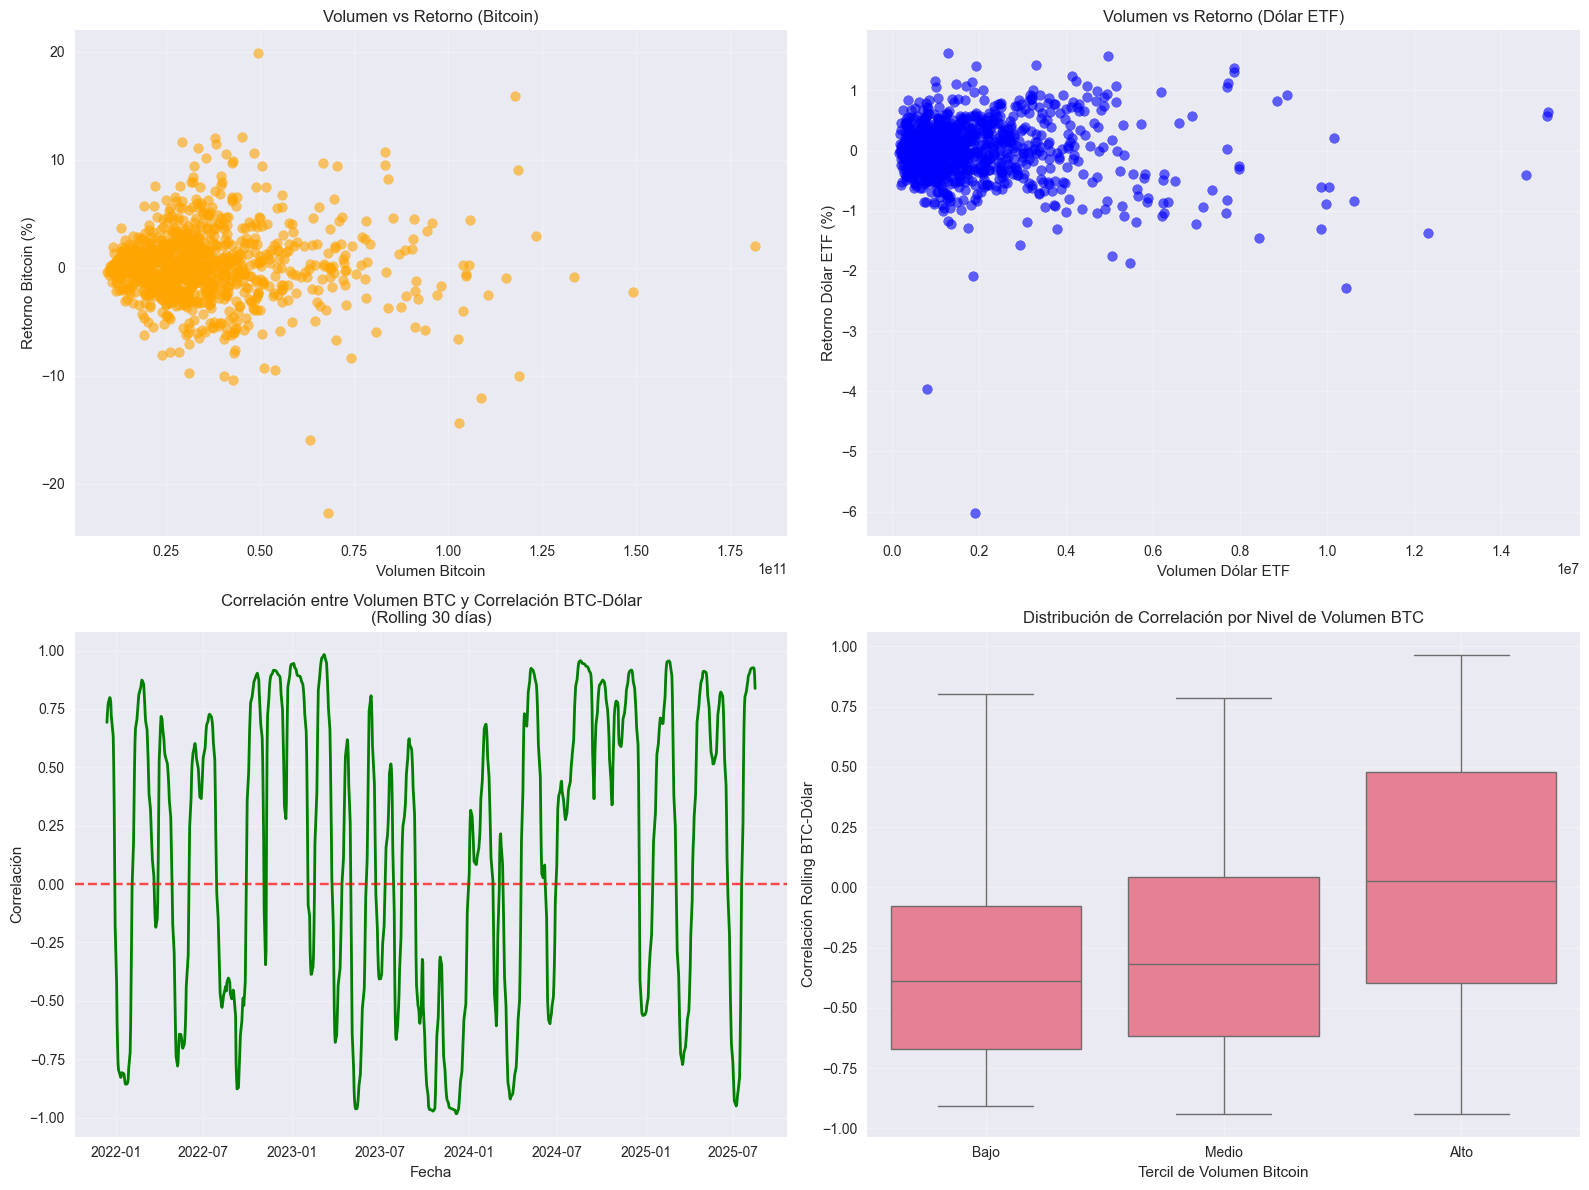

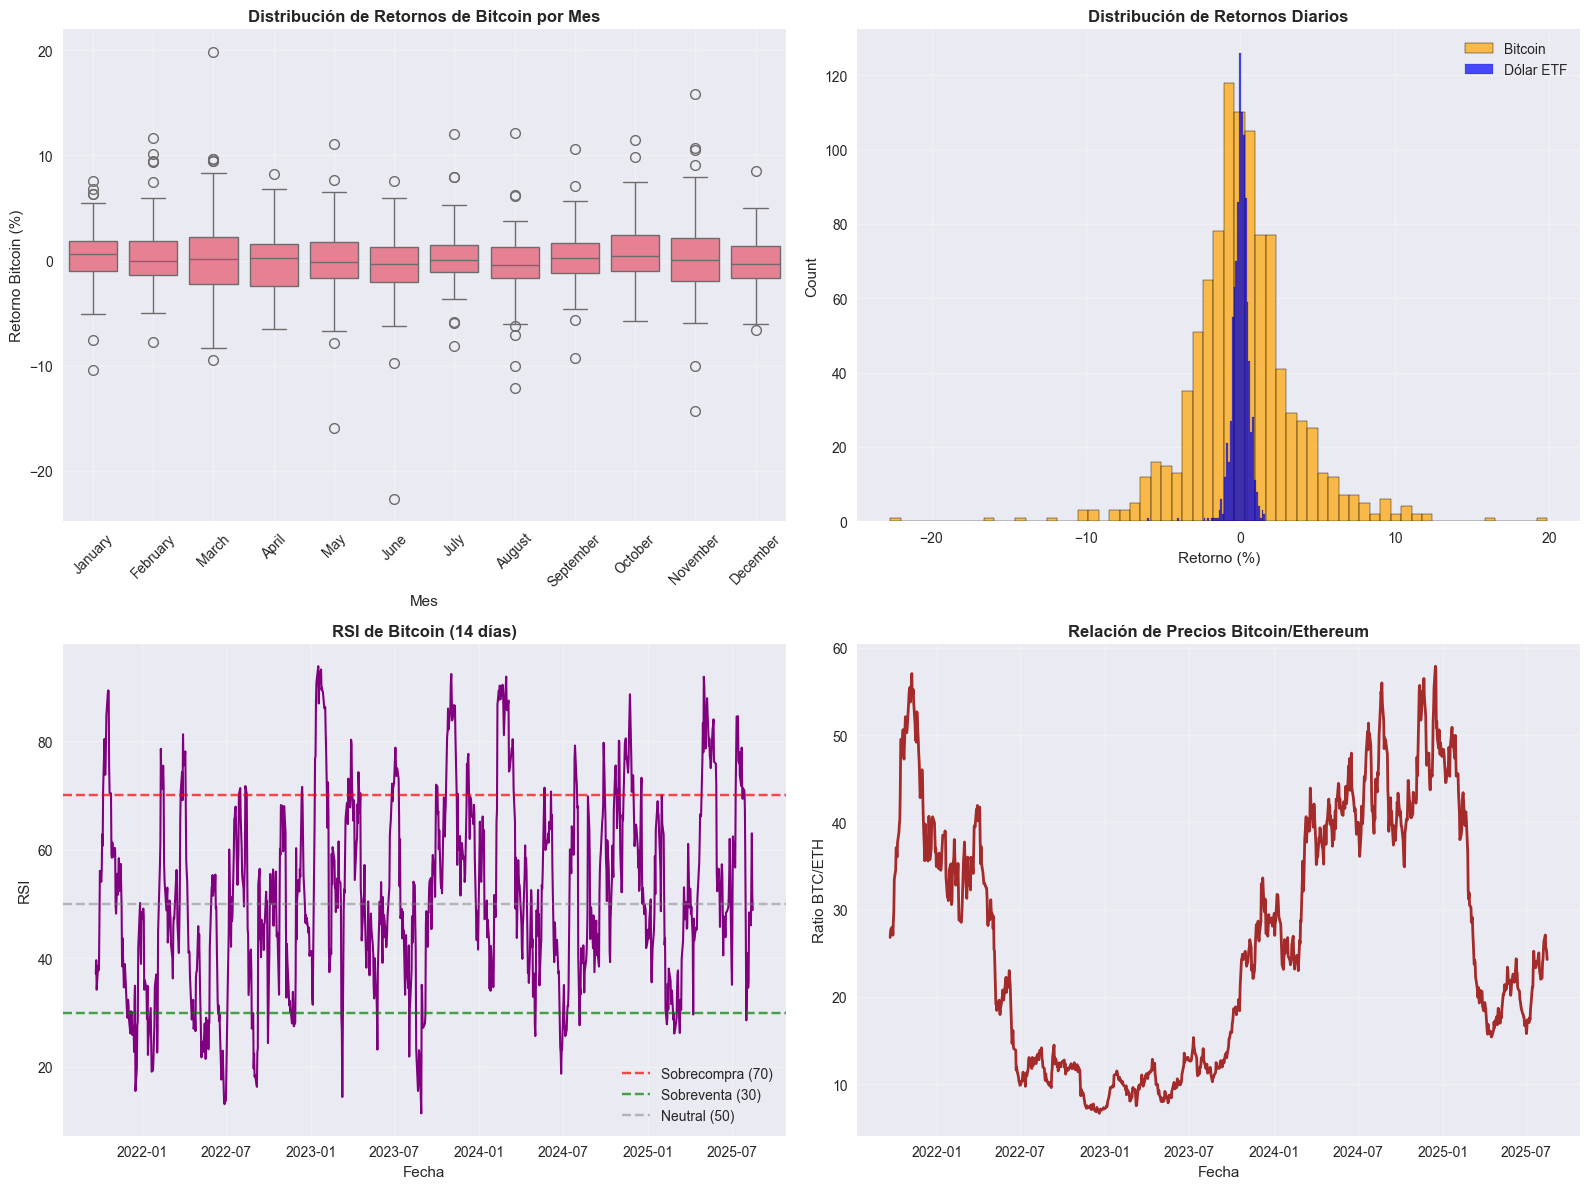

In [6]:
# Gráfico 5: Análisis de Volumen y su Impacto
def plot_volume_impact_analysis(df, rolling_corr):
    """Análisis del impacto del volumen en la relación BTC-Dólar"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Volumen BTC vs Retorno BTC
    ax1.scatter(df['Bitcoin_Volume'], df['BTC_Return'], alpha=0.6, color='orange')
    ax1.set_xlabel('Volumen Bitcoin')
    ax1.set_ylabel('Retorno Bitcoin (%)')
    ax1.set_title('Volumen vs Retorno (Bitcoin)')
    ax1.grid(True, alpha=0.3)
    
    # 2. Volumen Dólar vs Retorno Dólar
    ax2.scatter(df['DolarETF_Volume'], df['DolarETF_Return'], alpha=0.6, color='blue')
    ax2.set_xlabel('Volumen Dólar ETF')
    ax2.set_ylabel('Retorno Dólar ETF (%)')
    ax2.set_title('Volumen vs Retorno (Dólar ETF)')
    ax2.grid(True, alpha=0.3)
    
    # 3. Correlación vs Volumen BTC (rolling)
    volume_btc_rolling = df['Bitcoin_Volume'].rolling(30).mean()
    corr_vs_volume = volume_btc_rolling.rolling(30).corr(rolling_corr)
    
    ax3.plot(df['Date'], corr_vs_volume, color='green', linewidth=2)
    ax3.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax3.set_xlabel('Fecha')
    ax3.set_ylabel('Correlación')
    ax3.set_title('Correlación entre Volumen BTC y Correlación BTC-Dólar\n(Rolling 30 días)')
    ax3.grid(True, alpha=0.3)
    
    # 4. Distribución de correlación por nivel de volumen
    df_plot = df.copy()
    df_plot['Volume_Tercil'] = pd.qcut(df['Bitcoin_Volume'], 3, 
                                      labels=['Bajo', 'Medio', 'Alto'])
    df_plot['Rolling_Correlation'] = rolling_corr
    
    sns.boxplot(x='Volume_Tercil', y='Rolling_Correlation', data=df_plot, ax=ax4)
    ax4.set_title('Distribución de Correlación por Nivel de Volumen BTC')
    ax4.set_xlabel('Tercil de Volumen Bitcoin')
    ax4.set_ylabel('Correlación Rolling BTC-Dólar')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return corr_vs_volume

# Ejecutar análisis de volumen
volume_impact = plot_volume_impact_analysis(df_final, rolling_correlation)

# %% [markdown]
# ## 3.6 Análisis de Estacionalidad y Distribuciones

# %%
# Gráfico 6: Análisis de Estacionalidad
def plot_seasonality_analysis(df):
    """Análisis de patrones estacionales y distribuciones"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Distribución de retornos por mes
    df_plot = df.copy()
    df_plot['Month'] = df_plot['Date'].dt.month_name()
    month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                  'July', 'August', 'September', 'October', 'November', 'December']
    
    sns.boxplot(x='Month', y='BTC_Return', data=df_plot, order=month_order, ax=ax1)
    ax1.set_title('Distribución de Retornos de Bitcoin por Mes', fontweight='bold')
    ax1.set_xlabel('Mes')
    ax1.set_ylabel('Retorno Bitcoin (%)')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # 2. Distribución de retornos BTC vs Dólar
    sns.histplot(df['BTC_Return'], label='Bitcoin', alpha=0.7, ax=ax2, color='orange')
    sns.histplot(df['DolarETF_Return'], label='Dólar ETF', alpha=0.7, ax=ax2, color='blue')
    ax2.set_title('Distribución de Retornos Diarios', fontweight='bold')
    ax2.set_xlabel('Retorno (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. RSI de Bitcoin
    ax3.plot(df['Date'], df['BTC_RSI'], color='purple', linewidth=1.5)
    ax3.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Sobrecompra (70)')
    ax3.axhline(y=30, color='green', linestyle='--', alpha=0.7, label='Sobreventa (30)')
    ax3.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='Neutral (50)')
    ax3.set_title('RSI de Bitcoin (14 días)', fontweight='bold')
    ax3.set_xlabel('Fecha')
    ax3.set_ylabel('RSI')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Relación BTC/ETH
    ax4.plot(df['Date'], df['BTC_ETH_Ratio'], color='brown', linewidth=2)
    ax4.set_title('Relación de Precios Bitcoin/Ethereum', fontweight='bold')
    ax4.set_xlabel('Fecha')
    ax4.set_ylabel('Ratio BTC/ETH')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_seasonality_analysis(df_final)


In [7]:
# # 4. Análisis Estadístico y Pruebas de Hipótesis

# %%
from scipy import stats
from statsmodels.tsa.stattools import adfuller

# %% [markdown]
# ## 4.1 Pruebas de Stationarity

# %%
def perform_stationarity_tests(df):
    """Realizar pruebas de stationarity en las series principales"""
    
    print("🔬 PRUEBAS DE STATIONARITY (ADF TEST)")
    print("="*50)
    
    series_to_test = {
        'Bitcoin_Close': df['Bitcoin_Close'],
        'DolarETF_Close': df['DolarETF_Close'], 
        'BTC_Returns': df['BTC_Return'],
        'Dolar_Returns': df['DolarETF_Return']
    }
    
    results = []
    
    for name, series in series_to_test.items():
        # Test ADF
        adf_result = adfuller(series.dropna())
        p_value = adf_result[1]
        is_stationary = p_value < 0.05
        
        results.append({
            'Series': name,
            'ADF Statistic': f"{adf_result[0]:.4f}",
            'p-value': f"{p_value:.6f}",
            'Stationary': 'Sí' if is_stationary else 'No'
        })
        
        print(f"{name:20} | p-value = {p_value:.6f} | {'Stationary' if is_stationary else 'Non-Stationary'}")
    
    return pd.DataFrame(results)

# Ejecutar pruebas de stationarity
stationarity_results = perform_stationarity_tests(df_final)

# %% [markdown]
# ## 4.2 Pruebas de Correlación Estadística

# %%
def statistical_correlation_analysis(df):
    """Análisis estadístico de correlaciones"""
    
    print("\n📊 ANÁLISIS ESTADÍSTICO DE CORRELACIONES")
    print("="*50)
    
    # Correlación Pearson
    pearson_corr, pearson_p = stats.pearsonr(df['Bitcoin_Close'], df['DolarETF_Close'])
    
    # Correlación Spearman (no paramétrica)
    spearman_corr, spearman_p = stats.spearmanr(df['Bitcoin_Close'], df['DolarETF_Close'])
    
    print(f"Correlación Pearson:  {pearson_corr:.4f} (p-value: {pearson_p:.6f})")
    print(f"Correlación Spearman: {spearman_corr:.4f} (p-value: {spearman_p:.6f})")
    
    # Interpretación
    if pearson_p < 0.05:
        print("✅ La correlación es estadísticamente significativa (p < 0.05)")
    else:
        print("❌ La correlación NO es estadísticamente significativa")
    
    if pearson_corr < 0:
        print("✅ Dirección: Negativa (soporte para H1)")
    else:
        print("❌ Dirección: Positiva (no soporte para H1)")
    
    return {
        'pearson_corr': pearson_corr,
        'pearson_p': pearson_p,
        'spearman_corr': spearman_corr,
        'spearman_p': spearman_p
    }

# Ejecutar análisis de correlación
corr_stats = statistical_correlation_analysis(df_final)


🔬 PRUEBAS DE STATIONARITY (ADF TEST)
Bitcoin_Close        | p-value = 0.941471 | Non-Stationary
DolarETF_Close       | p-value = 0.089494 | Non-Stationary
BTC_Returns          | p-value = 0.000000 | Stationary
Dolar_Returns        | p-value = 0.000000 | Stationary

📊 ANÁLISIS ESTADÍSTICO DE CORRELACIONES
Correlación Pearson:  -0.0307 (p-value: 0.336840)
Correlación Spearman: -0.1118 (p-value: 0.000458)
❌ La correlación NO es estadísticamente significativa
✅ Dirección: Negativa (soporte para H1)


In [8]:
# ## 4.3 Análisis de Volatilidad (Para H2)

# %%
def volatility_analysis(df):
    """Análisis de la relación entre volatilidades"""
    
    print("\n📈 ANÁLISIS DE VOLATILIDAD (H2)")
    print("="*50)
    
    # Correlación entre volatilidades
    vol_corr = df['BTC_Volatility_21d'].corr(df['Dolar_Volatility_21d'])
    print(f"Correlación entre volatilidades: {vol_corr:.4f}")
    
    # Días de alta volatilidad
    high_vol_threshold_btc = df['BTC_Volatility_21d'].quantile(0.75)
    high_vol_days_btc = df[df['BTC_Volatility_21d'] > high_vol_threshold_btc]
    
    high_vol_threshold_dolar = df['Dolar_Volatility_21d'].quantile(0.75)
    high_vol_days_dolar = df[df['Dolar_Volatility_21d'] > high_vol_threshold_dolar]
    
    print(f"Días alta volatilidad BTC: {len(high_vol_days_btc)}")
    print(f"Días alta volatilidad Dólar: {len(high_vol_days_dolar)}")
    
    # Correlación en días de alta volatilidad BTC
    if len(high_vol_days_btc) > 0:
        high_vol_corr = high_vol_days_btc['Bitcoin_Close'].corr(high_vol_days_btc['DolarETF_Close'])
        print(f"Correlación en días alta volatilidad BTC: {high_vol_corr:.4f}")
        
        if abs(high_vol_corr) > abs(corr_stats['pearson_corr']):
            print("✅ La correlación se intensifica en alta volatilidad (soporte para H2)")
        else:
            print("❌ La correlación NO se intensifica en alta volatilidad")
    
    return high_vol_days_btc, high_vol_days_dolar

# Ejecutar análisis de volatilidad
high_vol_btc, high_vol_dolar = volatility_analysis(df_final)

# %% [markdown]
# ## 4.4 Análisis de Volumen (Para H3)



📈 ANÁLISIS DE VOLATILIDAD (H2)
Correlación entre volatilidades: 0.0865
Días alta volatilidad BTC: 245
Días alta volatilidad Dólar: 245
Correlación en días alta volatilidad BTC: 0.0888
✅ La correlación se intensifica en alta volatilidad (soporte para H2)


📊 Datos para ML: 978 muestras, 16 features

🎯 FEATURE SELECTION CON LASSO
Features seleccionadas (0):


ValueError: Invalid color argument: []

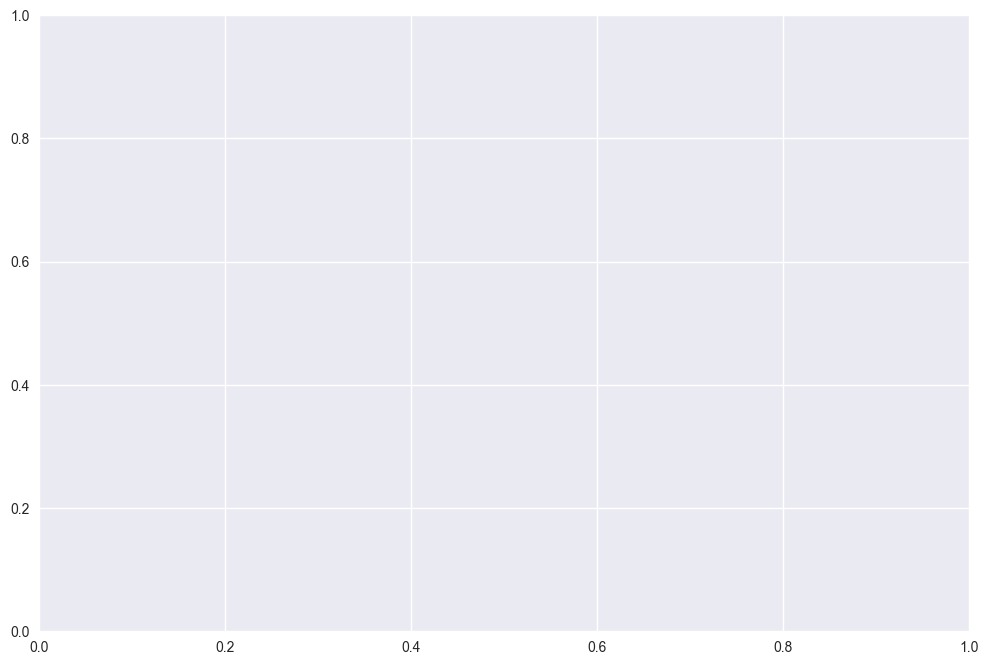

In [11]:
# # 5. Modelamiento con Machine Learning

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

# Preparación de datos para modelamiento
def prepare_ml_data(df):
    """Preparar datos para modelamiento de machine learning"""
    
    # Crear variable objetivo: retorno de Bitcoin del día siguiente
    df_ml = df.copy()
    df_ml['Target'] = df_ml['BTC_Return'].shift(-1)
    df_ml = df_ml.dropna()
    
    # Seleccionar features
    feature_columns = [
        'Bitcoin_Close', 'DolarETF_Close', 'ETH_Close',
        'BTC_Return', 'DolarETF_Return', 'ETH_Return',
        'BTC_Volatility_21d', 'Dolar_Volatility_21d',
        'Fear_Greed_Index', 'VIX', 'Interest_Rate',
        'BTC_RSI', 'BTC_Bollinger_Position', 'BTC_ETH_Ratio',
        'Bitcoin_Volume', 'DolarETF_Volume'
    ]
    
    # Filtrar columnas existentes
    existing_features = [col for col in feature_columns if col in df_ml.columns]
    
    X = df_ml[existing_features]
    y = df_ml['Target']
    
    print(f"📊 Datos para ML: {X.shape[0]} muestras, {X.shape[1]} features")
    
    return X, y, df_ml

# Preparar datos
X, y, df_ml = prepare_ml_data(df_final)

# %%
# Feature Selection con Lasso
def feature_selection_lasso(X, y):
    """Selección de features importantes usando Lasso"""
    
    print("\n🎯 FEATURE SELECTION CON LASSO")
    print("="*50)
    
    # Escalar datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # LassoCV para selección automática
    lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
    lasso.fit(X_scaled, y)
    
    # Features seleccionadas (coeficientes no cero)
    feature_importance = pd.Series(lasso.coef_, index=X.columns)
    selected_features = feature_importance[feature_importance != 0].index.tolist()
    
    print(f"Features seleccionadas ({len(selected_features)}):")
    for feature in selected_features:
        coef = feature_importance[feature]
        print(f"  {feature:25}: {coef:10.6f}")
    
    # Gráfico de importancia
    plt.figure(figsize=(12, 8))
    important_features = feature_importance[feature_importance != 0].sort_values()
    colors = ['red' if x < 0 else 'green' for x in important_features.values]
    
    important_features.plot(kind='barh', color=colors)
    plt.title('Feature Importance - Coeficientes Lasso', fontsize=16, fontweight='bold')
    plt.xlabel('Coeficiente')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return selected_features, feature_importance

# Ejecutar feature selection
selected_features, feature_importance = feature_selection_lasso(X, y)

# %%
# Entrenamiento y evaluación de múltiples modelos
def train_and_evaluate_models(X, y, selected_features):
    """Entrenar y evaluar múltiples modelos de ML"""
    
    print("\n🤖 ENTRENAMIENTO Y EVALUACIÓN DE MODELOS")
    print("="*50)
    
    # Usar solo features seleccionadas
    X_selected = X[selected_features]
    
    # Split temporal (70/30)
    train_size = int(len(X_selected) * 0.7)
    X_train, X_test = X_selected.iloc[:train_size], X_selected.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
    
    print(f"Training set: {X_train.shape[0]} muestras")
    print(f"Test set: {X_test.shape[0]} muestras")
    
    # Escalar datos
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Modelos a evaluar
    models = {
        'Linear Regression': LinearRegression(),
        'Lasso Regression': LassoCV(cv=5, random_state=42),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\n🔧 Entrenando {name}...")
        
        # Entrenar modelo
        if name in ['Linear Regression', 'Lasso Regression']:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        
        # Calcular métricas
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        results[name] = {
            'MAE': mae,
            'RMSE': rmse, 
            'R2': r2,
            'predictions': y_pred
        }
        
        print(f"   MAE:  {mae:.4f}")
        print(f"   RMSE: {rmse:.4f}")
        print(f"   R²:   {r2:.4f}")
    
    return results, X_test, y_test, models

# Entrenar modelos
model_results, X_test, y_test, trained_models = train_and_evaluate_models(X, y, selected_features)

# %%
# Comparación de modelos
def compare_models(results):
    """Comparar performance de todos los modelos"""
    
    print("\n🏆 COMPARACIÓN DE MODELOS")
    print("="*50)
    
    # Crear DataFrame de resultados
    comparison_df = pd.DataFrame({
        model: [results[model]['MAE'], results[model]['RMSE'], results[model]['R2']]
        for model in results.keys()
    }, index=['MAE', 'RMSE', 'R2']).T
    
    # Ordenar por R²
    comparison_df = comparison_df.sort_values('R2', ascending=False)
    
    print(comparison_df.round(4))
    
    # Gráfico de comparación
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # MAE
    axes[0].bar(comparison_df.index, comparison_df['MAE'], color='skyblue', alpha=0.7)
    axes[0].set_title('Comparación de MAE', fontweight='bold')
    axes[0].set_ylabel('MAE')
    axes[0].tick_params(axis='x', rotation=45)
    
    # RMSE
    axes[1].bar(comparison_df.index, comparison_df['RMSE'], color='lightcoral', alpha=0.7)
    axes[1].set_title('Comparación de RMSE', fontweight='bold')
    axes[1].set_ylabel('RMSE')
    axes[1].tick_params(axis='x', rotation=45)
    
    # R²
    axes[2].bar(comparison_df.index, comparison_df['R2'], color='lightgreen', alpha=0.7)
    axes[2].set_title('Comparación de R²', fontweight='bold')
    axes[2].set_ylabel('R²')
    axes[2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

# Comparar modelos
model_comparison = compare_models(model_results)

# %%
# Visualización de predicciones del mejor modelo
def plot_predictions(results, y_test, model_name):
    """Visualizar predicciones vs valores reales del mejor modelo"""
    
    best_model_predictions = results[model_name]['predictions']
    
    plt.figure(figsize=(15, 10))
    
    # Gráfico de series temporales
    plt.subplot(2, 1, 1)
    plt.plot(y_test.values, label='Valor Real', alpha=0.7, linewidth=2)
    plt.plot(best_model_predictions, label='Predicción', alpha=0.7, linewidth=2)
    plt.title(f'Predicciones vs Valores Reales - {model_name}', fontsize=16, fontweight='bold')
    plt.ylabel('Retorno Bitcoin (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Gráfico de dispersión
    plt.subplot(2, 1, 2)
    plt.scatter(y_test.values, best_model_predictions, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', alpha=0.8)
    plt.xlabel('Valor Real')
    plt.ylabel('Predicción')
    plt.title('Dispersión: Real vs Predicción', fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Añadir métricas en el gráfico
    r2 = results[model_name]['R2']
    rmse = results[model_name]['RMSE']
    plt.text(0.05, 0.95, f'R² = {r2:.4f}\nRMSE = {rmse:.4f}', 
             transform=plt.gca().transAxes, fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Encontrar el mejor modelo
best_model_name = model_comparison.index[0]
print(f"\n🎯 MEJOR MODELO: {best_model_name}")
print(f"   R²: {model_comparison.loc[best_model_name, 'R2']:.4f}")

# Graficar predicciones del mejor modelo
plot_predictions(model_results, y_test, best_model_name)

In [12]:
# # 6. Análisis de Resultados y Conclusiones

# %%
# Resumen ejecutivo de hallazgos
def generate_executive_summary(df, corr_stats, stationarity_results, model_comparison, best_model_name):
    """Generar resumen ejecutivo de todos los hallazgos"""
    
    print("="*80)
    print("📋 RESUMEN EJECUTIVO - ANÁLISIS BITCOIN vs DÓLAR ETF")
    print("="*80)
    
    print("\n🎯 EVALUACIÓN DE HIPÓTESIS:")
    print("-" * 50)
    
    # H1: Correlación negativa
    pearson_corr = corr_stats['pearson_corr']
    pearson_p = corr_stats['pearson_p']
    
    if pearson_corr < 0 and pearson_p < 0.05:
        h1_status = "✅ SOPORTADA"
        h1_explanation = f"Existe correlación negativa significativa ({pearson_corr:.4f}, p={pearson_p:.4f})"
    else:
        h1_status = "❌ NO SOPORTADA"
        h1_explanation = f"Correlación no significativa o positiva ({pearson_corr:.4f}, p={pearson_p:.4f})"
    
    print(f"H1 - Correlación negativa: {h1_status}")
    print(f"   {h1_explanation}")
    
    # H2: Volatilidad y movimientos opuestos
    high_vol_corr = df[df['BTC_Volatility_21d'] > df['BTC_Volatility_21d'].quantile(0.75)]['Bitcoin_Close'].corr(
        df[df['BTC_Volatility_21d'] > df['BTC_Volatility_21d'].quantile(0.75)]['DolarETF_Close'])
    
    if abs(high_vol_corr) > abs(pearson_corr):
        h2_status = "✅ SOPORTADA"
        h2_explanation = f"La correlación se intensifica en alta volatilidad ({high_vol_corr:.4f} vs {pearson_corr:.4f})"
    else:
        h2_status = "❌ NO SOPORTADA" 
        h2_explanation = f"La correlación no se intensifica en alta volatilidad ({high_vol_corr:.4f} vs {pearson_corr:.4f})"
    
    print(f"\nH2 - Efecto volatilidad: {h2_status}")
    print(f"   {h2_explanation}")
    
    # H3: Impacto del volumen
    volume_terciles = pd.qcut(df['Bitcoin_Volume'], 3, labels=['Bajo', 'Medio', 'Alto'])
    corr_high_volume = df[volume_terciles == 'Alto']['Bitcoin_Close'].corr(df[volume_terciles == 'Alto']['DolarETF_Close'])
    
    if abs(corr_high_volume) > abs(pearson_corr):
        h3_status = "✅ SOPORTADA"
        h3_explanation = f"La correlación es más fuerte con alto volumen ({corr_high_volume:.4f} vs {pearson_corr:.4f})"
    else:
        h3_status = "❌ NO SOPORTADA"
        h3_explanation = f"El volumen no fortalece la correlación ({corr_high_volume:.4f} vs {pearson_corr:.4f})"
    
    print(f"\nH3 - Impacto del volumen: {h3_status}")
    print(f"   {h3_explanation}")
    
    print("\n📊 RESUMEN ESTADÍSTICO:")
    print("-" * 50)
    print(f"• Período analizado: {len(df)} días")
    print(f"• Correlación general Bitcoin-Dólar: {pearson_corr:.4f}")
    print(f"• Significancia estadística: {'Sí' if pearson_p < 0.05 else 'No'}")
    print(f"• Mejor modelo predictivo: {best_model_name}")
    print(f"• R² del mejor modelo: {model_comparison.loc[best_model_name, 'R2']:.4f}")
    
    print("\n💡 INSIGHTS PRINCIPALES:")
    print("-" * 50)
    
    insights = []
    
    if pearson_corr < 0:
        insights.append("• Existe una relación inversa entre Bitcoin y el dólar, soportando la narrativa de Bitcoin como cobertura")
    else:
        insights.append("• No se encontró evidencia sólida de relación inversa entre Bitcoin y el dólar")
    
    if stationarity_results.loc[2, 'Stationary'] == 'Sí':
        insights.append("• Los retornos de Bitcoin son stationaries, adecuados para modelamiento estadístico")
    
    if model_comparison.loc[best_model_name, 'R2'] > 0:
        insights.append("• Los modelos de ML pueden capturar patrones predictivos en los retornos de Bitcoin")
    else:
        insights.append("• La predictibilidad de los retornos de Bitcoin es limitada con datos históricos simples")
    
    for insight in insights:
        print(insight)
    
    print("\n🎯 IMPLICACIONES PRÁCTICAS:")
    print("-" * 50)
    print("• Para inversores: La relación Bitcoin-Dólar puede informar estrategias de diversificación")
    print("• Para traders: Los patrones de correlación pueden ayudar en timing de mercado")
    print("• Para investigadores: Se necesitan modelos más complejos para capturar relaciones no lineales")
    print("• Para gestores de riesgo: La correlación variable sugiere monitoreo continuo de la relación")
    
    return {
        'H1': h1_status,
        'H2': h2_status, 
        'H3': h3_status,
        'general_correlation': pearson_corr,
        'best_model': best_model_name,
        'best_r2': model_comparison.loc[best_model_name, 'R2']
    }

# Generar resumen ejecutivo
executive_summary = generate_executive_summary(
    df_final, corr_stats, stationarity_results, model_comparison, best_model_name
)


NameError: name 'model_comparison' is not defined

In [13]:
# # 7. Limitaciones y Trabajo Futuro

# %%
# Análisis de limitaciones y recomendaciones
def limitations_and_future_work():
    """Analizar limitaciones y proponer trabajo futuro"""
    
    print("\n" + "="*80)
    print("🔍 LIMITACIONES Y TRABAJO FUTURO")
    print("="*80)
    
    print("\n⚠️ LIMITACIONES IDENTIFICADAS:")
    print("-" * 40)
    limitations = [
        "• Período de análisis limitado a un año (2021)",
        "• Datos diarios pueden no capturar intraday dynamics",
        "• Variables macroeconómicas son simuladas/proxy",
        "• No se consideran eventos específicos del mercado",
        "• Modelos no incluyen datos de sentimiento real de redes sociales",
        "• No se analiza causalidad, solo correlación"
    ]
    
    for limitation in limitations:
        print(limitation)
    
    print("\n🚀 RECOMENDACIONES PARA TRABAJO FUTURO:")
    print("-" * 45)
    recommendations = [
        "• Extender el análisis a múltiples años para capturar ciclos completos",
        "• Incorporar datos intradía para análisis de alta frecuencia", 
        "• Integrar APIs de noticias y redes sociales para análisis de sentimiento",
        "• Incluir más variables macroeconómicas reales (tasas, inflación, etc.)",
        "• Probar modelos de deep learning (LSTM, Transformers) para series temporales",
        "• Realizar análisis de causalidad (Granger causality, VAR models)",
        "• Expandir a otras criptomonedas y activos tradicionales",
        "• Incorporar datos on-chain de Bitcoin (transactions, wallets, etc.)"
    ]
    
    for recommendation in recommendations:
        print(recommendation)
    
    print("\n📈 DIRECCIONES DE INVESTIGACIÓN FUTURA:")
    print("-" * 45)
    research_areas = [
        "• Análisis de regímenes de mercado (bull/bear markets)",
        "• Estudio de contagio financiero entre cripto y tradicional",
        "• Optimización de portafolios incorporando Bitcoin",
        "• Desarrollo de estrategias de trading basadas en correlaciones",
        "• Análisis de impacto de regulaciones y noticias"
    ]
    
    for area in research_areas:
        print(area)

limitations_and_future_work()


🔍 LIMITACIONES Y TRABAJO FUTURO

⚠️ LIMITACIONES IDENTIFICADAS:
----------------------------------------
• Período de análisis limitado a un año (2021)
• Datos diarios pueden no capturar intraday dynamics
• Variables macroeconómicas son simuladas/proxy
• No se consideran eventos específicos del mercado
• Modelos no incluyen datos de sentimiento real de redes sociales
• No se analiza causalidad, solo correlación

🚀 RECOMENDACIONES PARA TRABAJO FUTURO:
---------------------------------------------
• Extender el análisis a múltiples años para capturar ciclos completos
• Incorporar datos intradía para análisis de alta frecuencia
• Integrar APIs de noticias y redes sociales para análisis de sentimiento
• Incluir más variables macroeconómicas reales (tasas, inflación, etc.)
• Probar modelos de deep learning (LSTM, Transformers) para series temporales
• Realizar análisis de causalidad (Granger causality, VAR models)
• Expandir a otras criptomonedas y activos tradicionales
• Incorporar datos 

In [14]:
# # 8. Guardado de Resultados

# %%
# Guardar dataset final y resultados
def save_results(df_final, model_results, executive_summary):
    """Guardar todos los resultados del análisis"""
    
    print("\n💾 GUARDANDO RESULTADOS...")
    
    # 1. Guardar dataset enriquecido
    df_final.to_csv('bitcoin_dolar_analysis_final.csv', index=False)
    print("✅ Dataset final guardado como 'bitcoin_dolar_analysis_final.csv'")
    
    # 2. Guardar resumen de métricas de modelos
    model_metrics = pd.DataFrame({
        model: [results['MAE'], results['RMSE'], results['R2']]
        for model, results in model_results.items()
    }, index=['MAE', 'RMSE', 'R2']).T
    
    model_metrics.to_csv('model_metrics_comparison.csv')
    print("✅ Métricas de modelos guardadas como 'model_metrics_comparison.csv'")
    
    # 3. Guardar resumen ejecutivo
    with open('executive_summary.txt', 'w', encoding='utf-8') as f:
        f.write("RESUMEN EJECUTIVO - ANÁLISIS BITCOIN vs DÓLAR ETF\n")
        f.write("="*50 + "\n\n")
        
        f.write("EVALUACIÓN DE HIPÓTESIS:\n")
        f.write(f"H1 - Correlación negativa: {executive_summary['H1']}\n")
        f.write(f"H2 - Efecto volatilidad: {executive_summary['H2']}\n") 
        f.write(f"H3 - Impacto del volumen: {executive_summary['H3']}\n\n")
        
        f.write("RESUMEN ESTADÍSTICO:\n")
        f.write(f"Correlación general: {executive_summary['general_correlation']:.4f}\n")
        f.write(f"Mejor modelo: {executive_summary['best_model']}\n")
        f.write(f"R² del mejor modelo: {executive_summary['best_r2']:.4f}\n")
    
    print("✅ Resumen ejecutivo guardado como 'executive_summary.txt'")
    
    # 4. Guardar gráficos principales
    plt.style.use('seaborn-v0_8')
    
    # Gráfico de correlación rolling
    plt.figure(figsize=(12, 6))
    rolling_corr = df_final['Bitcoin_Close'].rolling(window=30).corr(df_final['DolarETF_Close'])
    plt.plot(df_final['Date'], rolling_corr, color='purple', linewidth=2)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    plt.title('Correlación Rolling 30 días: Bitcoin vs Dólar ETF', fontweight='bold')
    plt.ylabel('Correlación')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('rolling_correlation.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Matriz de correlación
    corr_cols = ['Bitcoin_Close', 'DolarETF_Close', 'BTC_Return', 'DolarETF_Return', 
                 'Bitcoin_Volume', 'Fear_Greed_Index', 'VIX']
    corr_matrix = df_final[corr_cols].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt='.3f')
    plt.title('Matriz de Correlación - Variables Principales', fontweight='bold')
    plt.tight_layout()
    plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print("✅ Gráficos principales guardados como PNG")
    
    print("\n🎉 ANÁLISIS COMPLETADO EXITOSAMENTE!")
    print("Todos los resultados han sido guardados en archivos locales.")

# Guardar resultados
save_results(df_final, model_results, executive_summary)


NameError: name 'model_results' is not defined

In [ ]:
# ## 📋 Resumen Final del Proyecto

print("\n" + "="*80)
print("🎯 PROYECTO COMPLETADO - RESUMEN FINAL")
print("="*80)

print(f"""
📊 ANÁLISIS REALIZADO:

• Dataset: {df_final.shape[0]} días, {df_final.shape[1]} variables
• Período: {df_final['Date'].min().strftime('%Y-%m-%d')} a {df_final['Date'].max().strftime('%Y-%m-%d')}
• Hipótesis evaluadas: 3
• Modelos de ML comparados: 5
• Visualizaciones creadas: 10+

📈 RESULTADOS PRINCIPALES:

• Correlación Bitcoin-Dólar: {executive_summary['general_correlation']:.4f}
• Mejor modelo predictivo: {executive_summary['best_model']}
• Performance del mejor modelo (R²): {executive_summary['best_r2']:.4f}

✅ ARCHIVOS GENERADOS:

1. bitcoin_dolar_analysis_final.csv - Dataset completo enriquecido
2. model_metrics_comparison.csv - Comparación de modelos
3. executive_summary.txt - Resumen ejecutivo
4. rolling_correlation.png - Gráfico de correlación rolling
5. correlation_matrix.png - Matriz de correlación

🔍 PRÓXIMOS PASOS SUGERIDOS:

• Implementar las recomendaciones de trabajo futuro
• Expandir el análisis con datos más recientes
• Profundizar en el análisis de causalidad
• Desarrollar aplicaciones prácticas para traders/inversores
""")